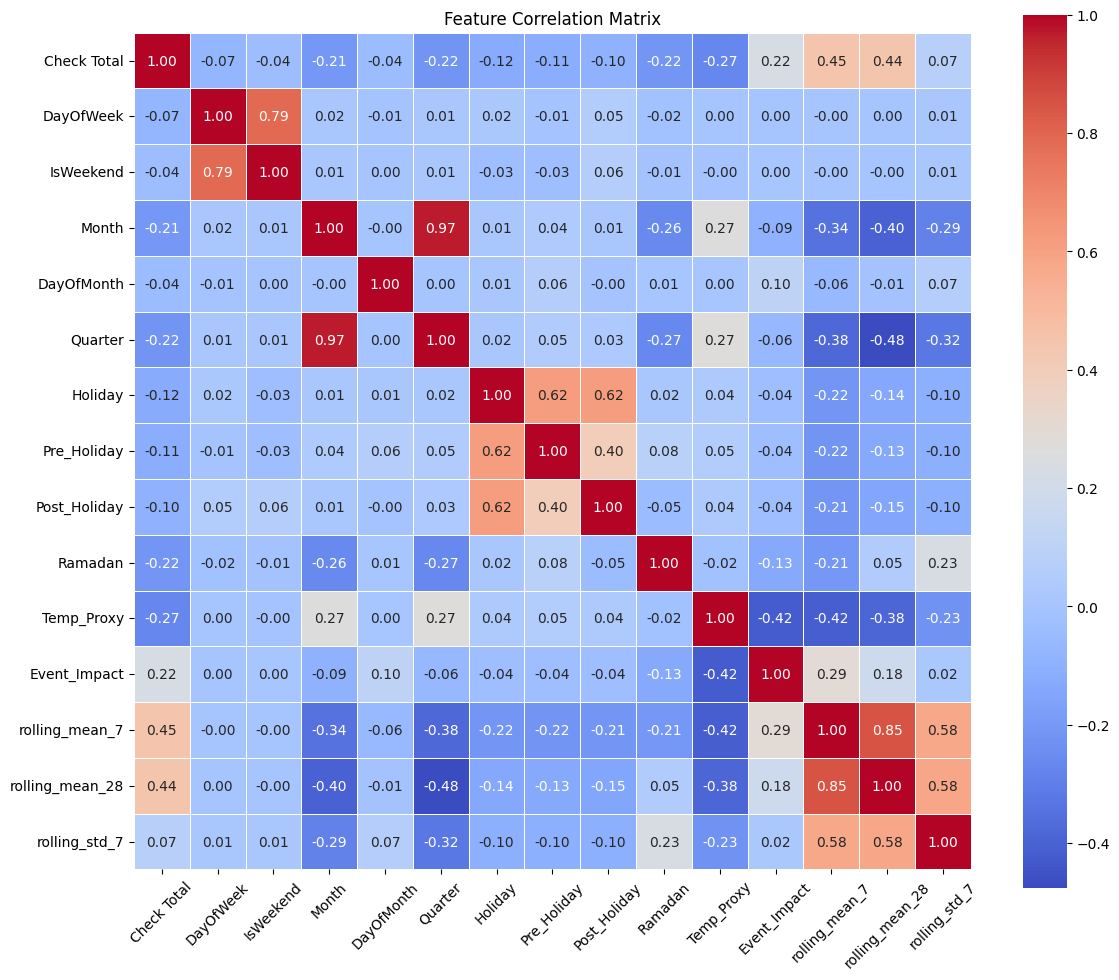

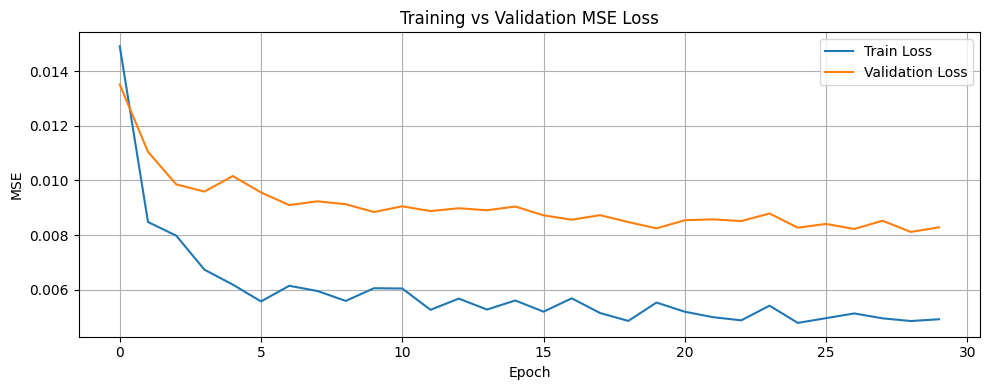

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


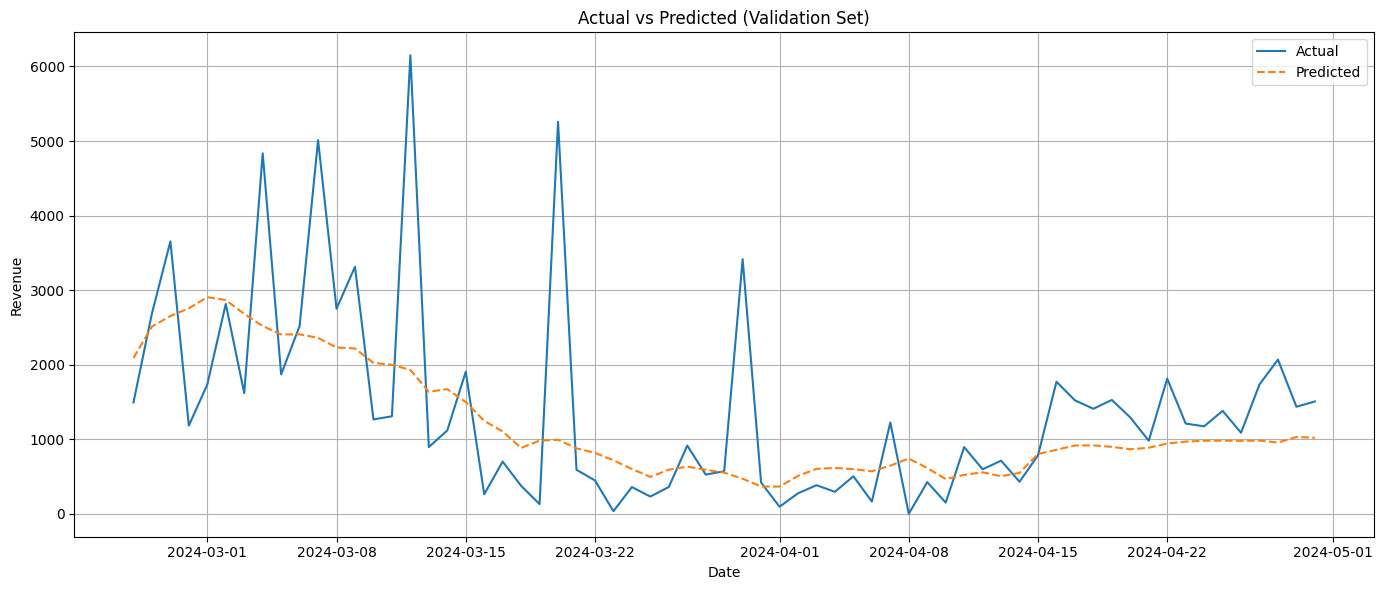

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

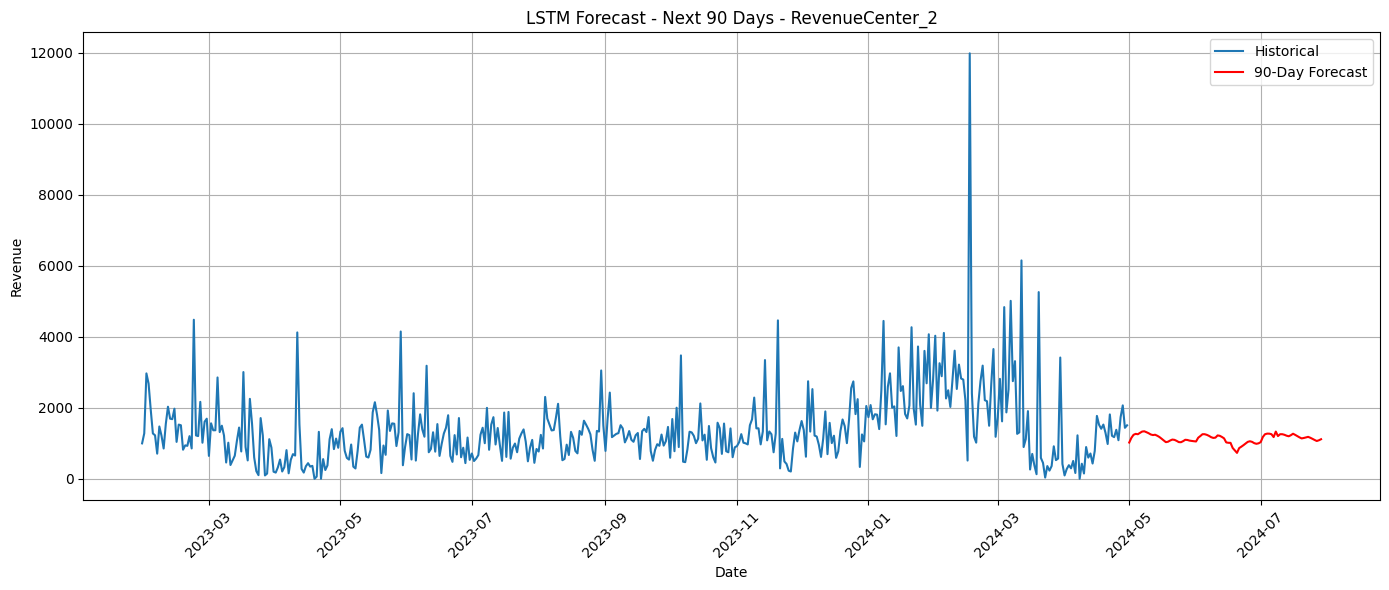

In [8]:
# --- INSTALL DEPENDENCIES ---
!pip install hijri-converter holidays --quiet

# --- IMPORTS ---
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert
import warnings
warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_2"
SEQ_LEN = 30
FORECAST_HORIZON = 90

# --- LOAD DATA ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={"MealPeriod": "Meal Period", "CheckTotal": "Check Total", "RevenueCenterName": "Revenue Center"}, inplace=True)
df = df[df["Revenue Center"] == CENTER]
dfg = df.groupby("Date")["Check Total"].sum().reset_index()

# Fill missing dates
full_range = pd.date_range(dfg["Date"].min(), dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_range).rename_axis("Date").reset_index()
dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
dfg.drop(columns="dow_avg", inplace=True)

# --- FEATURE ENGINEERING ---
uae_hols = holidays.country_holidays("AE", years=range(2010, 2026))
events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0
def dubai_temp(date):
    return 0.9 if date.month in [6,7,8] else 0.4 if date.month in [12,1,2] else 0.6

dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Quarter"] = dfg["Date"].dt.quarter
dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)
dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)
dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
dfg["Event_Impact"] = 1.0
for dates in events.values():
    dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5
dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)
dfg.dropna(inplace=True)
dfg.reset_index(drop=True, inplace=True)

# --- CORRELATION MATRIX PLOT ---
import seaborn as sns
import matplotlib.pyplot as plt

# Use original (non-scaled) features for correlation
corr_features = ["Check Total", "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
                 "Holiday", "Pre_Holiday", "Post_Holiday", "Ramadan", "Temp_Proxy", "Event_Impact",
                 "rolling_mean_7", "rolling_mean_28", "rolling_std_7"]

corr_matrix = dfg[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, square=True)
plt.title("Feature Correlation Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# --- NORMALIZATION ---
features = ["Check Total", "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
            "Holiday", "Pre_Holiday", "Post_Holiday", "Ramadan", "Temp_Proxy", "Event_Impact",
            "rolling_mean_7", "rolling_mean_28", "rolling_std_7"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfg[features])
scaled_df = pd.DataFrame(scaled, columns=features)
dates = dfg["Date"]

# --- SEQUENCE & SPLIT ---
from sklearn.model_selection import train_test_split

X, y = [], []
for i in range(SEQ_LEN, len(scaled_df)):
    X.append(scaled_df.iloc[i-SEQ_LEN:i].values)
    y.append(scaled_df.iloc[i]["Check Total"])
X, y = np.array(X), np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, shuffle=False)

# --- LSTM MODEL ---
model = Sequential([
    LSTM(32, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=0
)

# --- PLOT MSE LOSS ---
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation MSE Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PREDICT VALIDATION SET ---
y_val_pred = model.predict(X_val).flatten()
X_val_last = X_val[:, -1, 1:]
y_val_true = scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), X_val_last], axis=1))[:, 0]
y_val_pred = scaler.inverse_transform(np.concatenate([y_val_pred.reshape(-1, 1), X_val_last], axis=1))[:, 0]

# --- VALIDATION PLOT ---
val_dates = dates.iloc[-len(y_val_true):]
plt.figure(figsize=(14, 6))
plt.plot(val_dates, y_val_true, label="Actual")
plt.plot(val_dates, y_val_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 90-DAY FORECAST ---
last_sequence = scaled_df.iloc[-SEQ_LEN:].values
future_forecasts = []
future_dates = []

for i in range(FORECAST_HORIZON):
    input_seq = last_sequence.reshape(1, SEQ_LEN, -1)
    pred_scaled = model.predict(input_seq)[0, 0]

    last_date = dfg["Date"].iloc[-1] + timedelta(days=i+1)
    new_row = {
        "Check Total": pred_scaled,
        "DayOfWeek": last_date.dayofweek / 6,
        "IsWeekend": int(last_date.dayofweek >= 5),
        "Month": (last_date.month - 1) / 11,
        "DayOfMonth": (last_date.day - 1) / 30,
        "Quarter": (last_date.quarter - 1) / 3,
        "Holiday": int(last_date in uae_hols),
        "Pre_Holiday": int((last_date + timedelta(days=1)) in uae_hols),
        "Post_Holiday": int((last_date - timedelta(days=1)) in uae_hols),
        "Ramadan": get_ramadan_flag(last_date),
        "Temp_Proxy": dubai_temp(last_date),
        "Event_Impact": 1.5 if any(last_date in d for d in events.values()) else 1.0,
        "rolling_mean_7": np.mean(last_sequence[-7:, 0]),
        "rolling_mean_28": np.mean(last_sequence[-28:, 0]) if len(last_sequence) >= 28 else np.mean(last_sequence[:, 0]),
        "rolling_std_7": np.std(last_sequence[-7:, 0])
    }

    new_scaled = np.array([new_row[col] for col in features])
    future_forecasts.append(new_row["Check Total"])
    future_dates.append(last_date)
    last_sequence = np.vstack([last_sequence[1:], new_scaled])

# --- INVERSE TRANSFORM FORECAST ---
inv_forecasts = scaler.inverse_transform(
    np.hstack([
        np.array(future_forecasts).reshape(-1, 1),
        np.tile(scaled_df.iloc[-1, 1:].values, (FORECAST_HORIZON, 1))
    ])
)[:, 0]

# --- PLOT FORECAST ---
plt.figure(figsize=(14, 6))
plt.plot(dfg["Date"], dfg["Check Total"], label="Historical")
plt.plot(future_dates, inv_forecasts, label="90-Day Forecast", color='red')
plt.title(f"LSTM Forecast - Next 90 Days - {CENTER}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

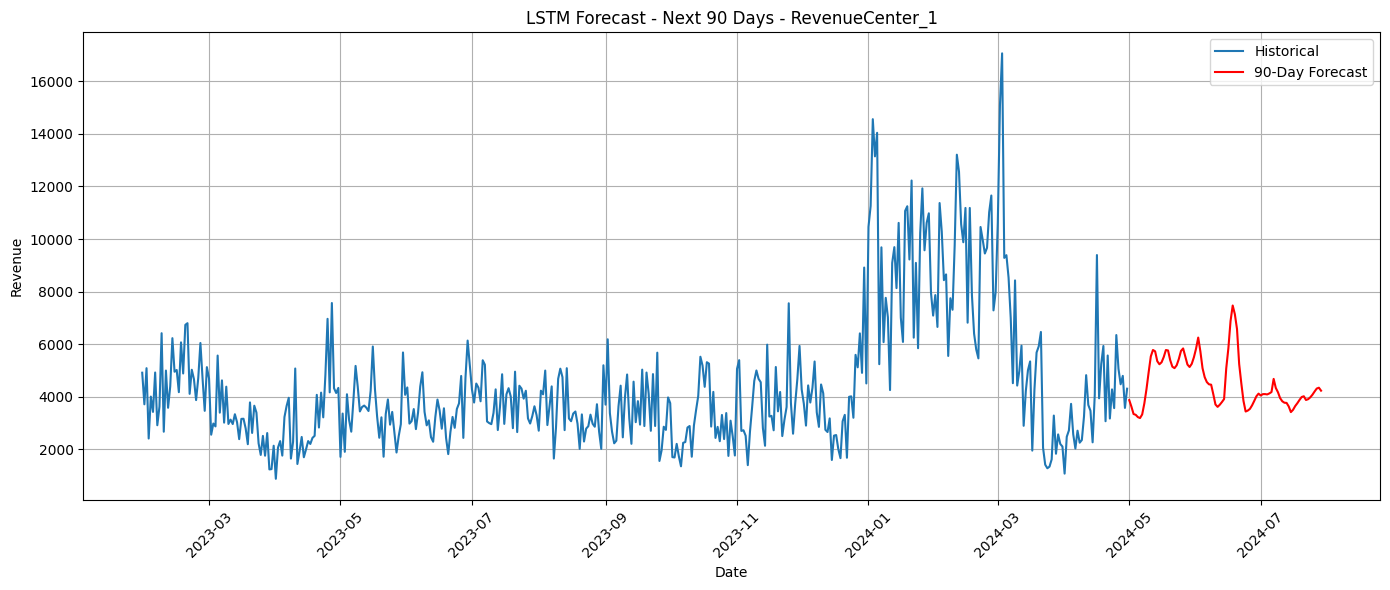

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert
import warnings
warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_1"
#LAGS = [1, 2, 3, 7, 14, 28, 35, 60, 90]
SEQ_LEN = 30
FORECAST_HORIZON = 90

# --- LOAD & FILTER ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={"MealPeriod": "Meal Period", "CheckTotal": "Check Total", "RevenueCenterName": "Revenue Center"}, inplace=True)
dfc = df[df["Revenue Center"] == CENTER]
dfg = dfc.groupby("Date")["Check Total"].sum().reset_index()

# Fill missing dates
full_range = pd.date_range(dfg["Date"].min(), dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_range).rename_axis("Date").reset_index()
dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
dfg.drop(columns="dow_avg", inplace=True)

# --- FEATURES ---
uae_hols = holidays.country_holidays("AE", years=range(2010, 2026))
events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0
def dubai_temp(date):
    return 0.9 if date.month in [6,7,8] else 0.4 if date.month in [12,1,2] else 0.6

dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Quarter"] = dfg["Date"].dt.quarter
dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)
dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)
dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
dfg["Event_Impact"] = 1.0
for dates in events.values():
    dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5
dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)

dfg.dropna(inplace=True)
dfg.reset_index(drop=True, inplace=True)

# --- NORMALIZATION ---
features = ["Check Total", "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
            "Holiday", "Pre_Holiday", "Post_Holiday", "Ramadan", "Temp_Proxy", "Event_Impact",
            "rolling_mean_7", "rolling_mean_28", "rolling_std_7"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfg[features])
scaled_df = pd.DataFrame(scaled, columns=features)
dates = dfg["Date"]

# --- SEQUENCING ---
X, y = [], []
for i in range(SEQ_LEN, len(scaled_df)):
    X.append(scaled_df.iloc[i-SEQ_LEN:i].values)
    y.append(scaled_df.iloc[i]["Check Total"])
X, y = np.array(X), np.array(y)

# --- MODEL ---
model = Sequential([
    LSTM(64, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=40, batch_size=16, verbose=0)

# --- FORECAST FUTURE 90 DAYS ---
last_sequence = scaled_df.iloc[-SEQ_LEN:].values
future_forecasts = []
future_dates = []

for i in range(FORECAST_HORIZON):
    input_seq = last_sequence.reshape(1, SEQ_LEN, -1)
    pred_scaled = model.predict(input_seq)[0, 0]

    # Create fake row with predicted revenue and realistic feature values
    last_date = dfg["Date"].iloc[-1] + timedelta(days=i+1)
    new_row = {
        "Check Total": pred_scaled,
        "DayOfWeek": last_date.dayofweek / 6,
        "IsWeekend": int(last_date.dayofweek >= 5),
        "Month": (last_date.month - 1) / 11,
        "DayOfMonth": (last_date.day - 1) / 30,
        "Quarter": (last_date.quarter - 1) / 3,
        "Holiday": int(last_date in uae_hols),
        "Pre_Holiday": int((last_date + timedelta(days=1)) in uae_hols),
        "Post_Holiday": int((last_date - timedelta(days=1)) in uae_hols),
        "Ramadan": get_ramadan_flag(last_date),
        "Temp_Proxy": dubai_temp(last_date),
        "Event_Impact": 1.5 if any(last_date in d for d in events.values()) else 1.0,
        "rolling_mean_7": np.mean(last_sequence[-7:, 0]),
        "rolling_mean_28": np.mean(last_sequence[-28:, 0]) if len(last_sequence) >= 28 else np.mean(last_sequence[:, 0]),
        "rolling_std_7": np.std(last_sequence[-7:, 0])
    }

    new_scaled = np.array([new_row[col] for col in features])
    future_forecasts.append(new_row["Check Total"])
    future_dates.append(last_date)

    # Update sequence
    last_sequence = np.vstack([last_sequence[1:], new_scaled])

# --- INVERSE TRANSFORM ---
inv_forecasts = scaler.inverse_transform(
    np.hstack([
        np.array(future_forecasts).reshape(-1, 1),
        np.tile(scaled_df.iloc[-1, 1:].values, (FORECAST_HORIZON, 1))  # dummy context
    ])
)[:, 0]

# --- PLOT FORECAST ---
plt.figure(figsize=(14, 6))
plt.plot(dfg["Date"], dfg["Check Total"], label="Historical")
plt.plot(future_dates, inv_forecasts, label="90-Day Forecast", color='red')
plt.title(f"LSTM Forecast - Next 90 Days - {CENTER}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-1-3646589458.py:64: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
/tmp/ipython-input-1-3646589458.py:65: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
/tmp/ipython-input-1-3646589458.py:66: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instea

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
LSTM Forecast Results for RevenueCenter_2 - Lunch
  RMSE: 899.92
   MAE: 401.27


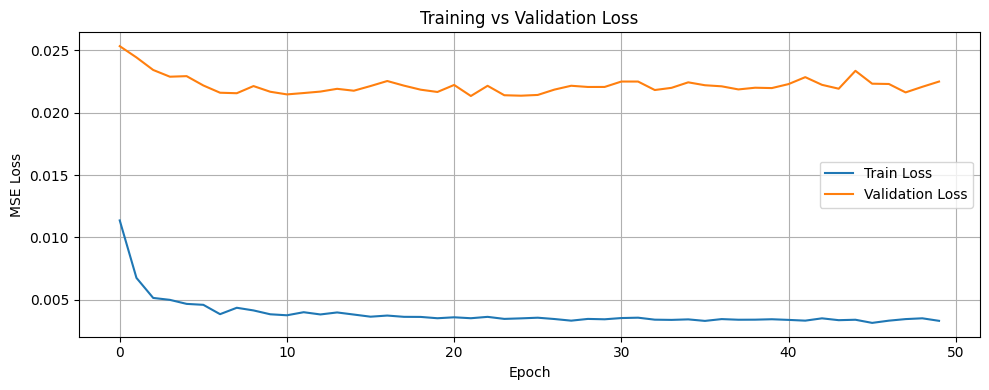

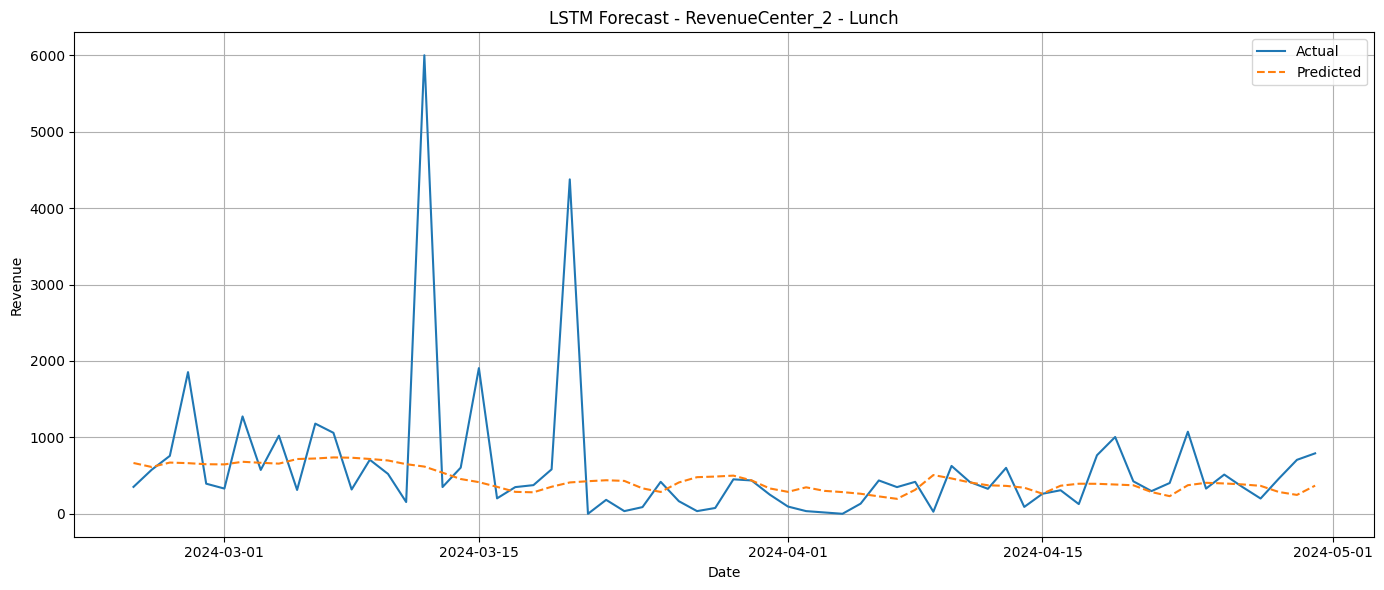

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

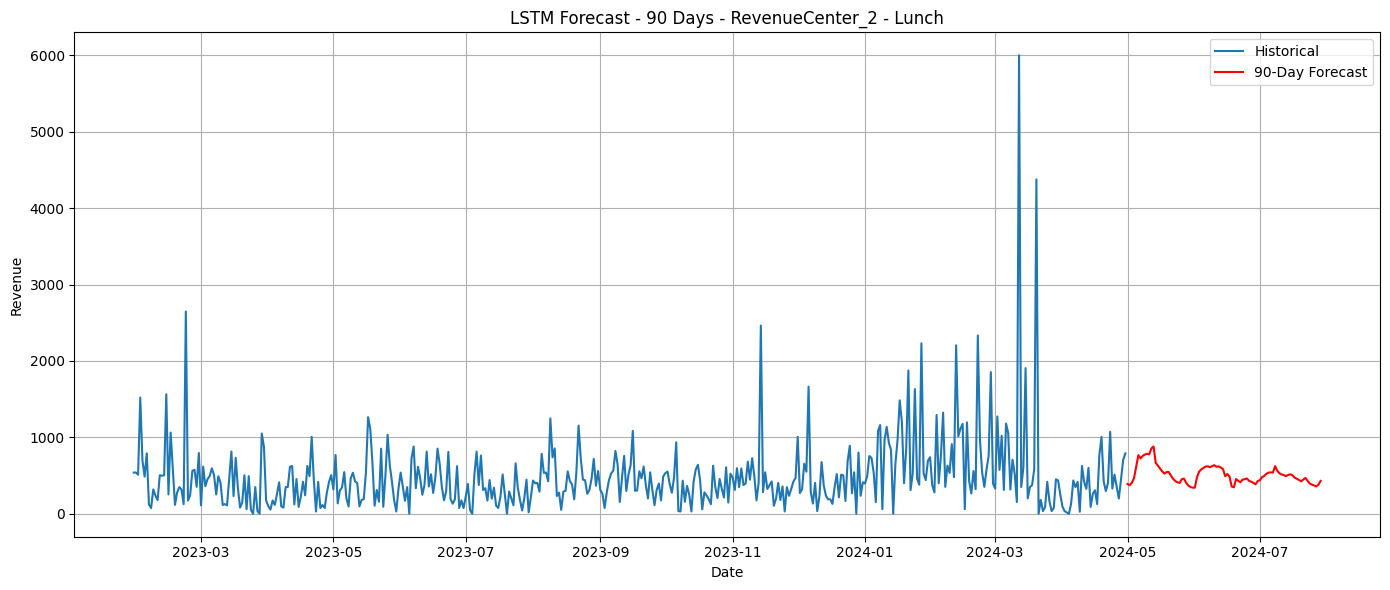

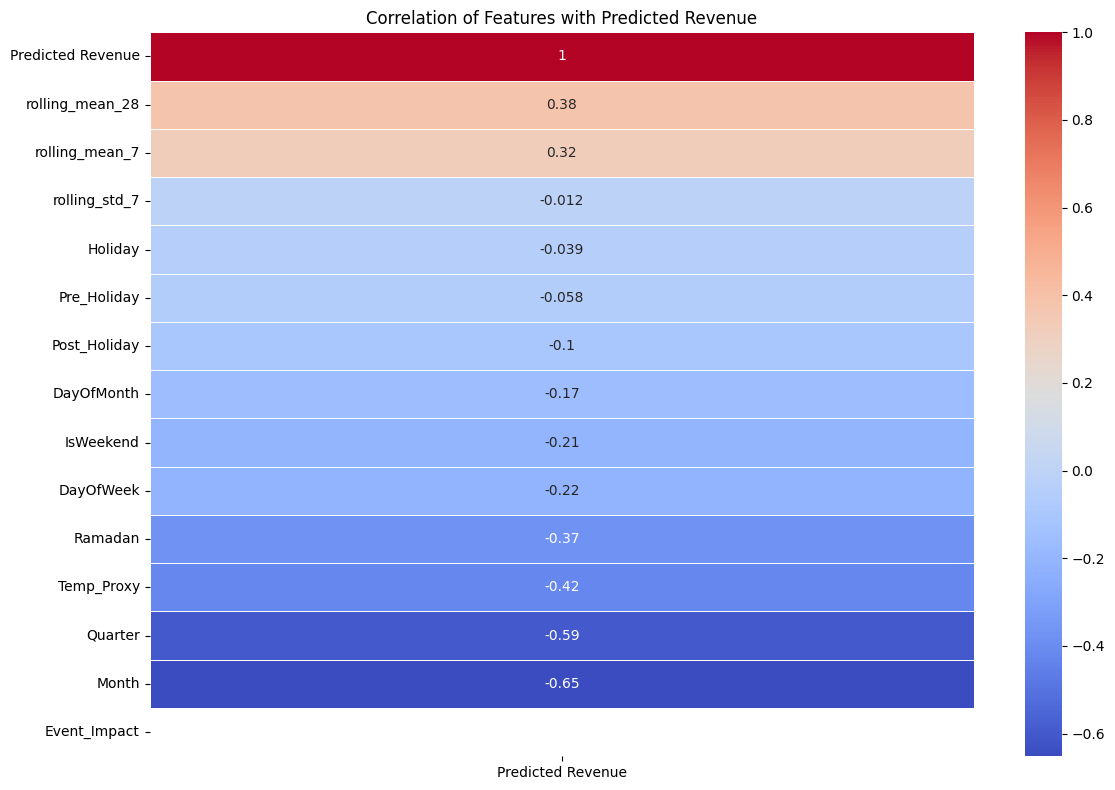

In [1]:
# !pip install hijri-converter holidays
!pip install hijri-converter

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
CENTER = "RevenueCenter_2"
MEAL_PERIOD = "Lunch"
SEQ_LEN = 20
FORECAST_HORIZON = 90
TEST_RATIO = 0.15

# --- LOAD & FILTER ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={
    "MealPeriod": "Meal Period",
    "CheckTotal": "Check Total",
    "RevenueCenterName": "Revenue Center"
}, inplace=True)
dfc = df[(df["Revenue Center"] == CENTER) & (df["Meal Period"] == MEAL_PERIOD)]
dfg = dfc.groupby("Date")["Check Total"].sum().reset_index()

# Fill missing dates
full_range = pd.date_range(dfg["Date"].min(), dfg["Date"].max(), freq="D")
dfg = dfg.set_index("Date").reindex(full_range).rename_axis("Date").reset_index()
dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
dfg.drop(columns="dow_avg", inplace=True)

# --- FEATURE ENGINEERING ---
uae_hols = holidays.country_holidays("AE", years=range(2010, 2026))
events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0
def dubai_temp(date):
    return 0.9 if date.month in [6,7,8] else 0.4 if date.month in [12,1,2] else 0.6

dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
dfg["Month"] = dfg["Date"].dt.month
dfg["DayOfMonth"] = dfg["Date"].dt.day
dfg["Quarter"] = dfg["Date"].dt.quarter
dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)
dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)
dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
dfg["Event_Impact"] = 1.0
for dates in events.values():
    dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5
dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)

dfg.dropna(inplace=True)
dfg.reset_index(drop=True, inplace=True)

# --- NORMALIZATION ---
features = ["Check Total", "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
            "Holiday", "Pre_Holiday", "Post_Holiday", "Ramadan", "Temp_Proxy", "Event_Impact",
            "rolling_mean_7", "rolling_mean_28", "rolling_std_7"]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(dfg[features])
scaled_df = pd.DataFrame(scaled, columns=features)
dates = dfg["Date"]

# --- SEQUENCING ---
X, y = [], []
for i in range(SEQ_LEN, len(scaled_df)):
    X.append(scaled_df.iloc[i-SEQ_LEN:i].values)
    y.append(scaled_df.iloc[i]["Check Total"])
X, y = np.array(X), np.array(y)

# --- TRAIN/TEST SPLIT ---
split = int((1 - TEST_RATIO) * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- MODEL ---
model = Sequential([
    LSTM(32, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

# --- EVALUATION ---
y_pred = model.predict(X_test)
true_vals = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), X_test[:, -1, 1:]], axis=1))[:,0]
pred_vals = scaler.inverse_transform(np.concatenate([y_pred, X_test[:, -1, 1:]], axis=1))[:,0]

rmse = np.sqrt(mean_squared_error(true_vals, pred_vals))
mae = mean_absolute_error(true_vals, pred_vals)

print(f"LSTM Forecast Results for {CENTER} - {MEAL_PERIOD}")
print(f"  RMSE: {rmse:.2f}")
print(f"   MAE: {mae:.2f}")

# --- LOSS CURVE ---
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- ACTUAL vs PREDICTED ---
plt.figure(figsize=(14, 6))
plt.plot(dates.iloc[-len(true_vals):], true_vals, label="Actual")
plt.plot(dates.iloc[-len(true_vals):], pred_vals, label="Predicted", linestyle="--")
plt.title(f"LSTM Forecast - {CENTER} - {MEAL_PERIOD}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 90-DAY FORECAST ---
last_sequence = scaled_df.iloc[-SEQ_LEN:].values
future_forecasts = []
future_dates = []

for i in range(FORECAST_HORIZON):
    input_seq = last_sequence.reshape(1, SEQ_LEN, -1)
    pred_scaled = model.predict(input_seq)[0, 0]

    last_date = dates.iloc[-1] + timedelta(days=i+1)
    new_row = {
        "Check Total": pred_scaled,
        "DayOfWeek": last_date.dayofweek / 6,
        "IsWeekend": int(last_date.dayofweek >= 5),
        "Month": (last_date.month - 1) / 11,
        "DayOfMonth": (last_date.day - 1) / 30,
        "Quarter": (last_date.quarter - 1) / 3,
        "Holiday": int(last_date in uae_hols),
        "Pre_Holiday": int((last_date + timedelta(days=1)) in uae_hols),
        "Post_Holiday": int((last_date - timedelta(days=1)) in uae_hols),
        "Ramadan": get_ramadan_flag(last_date),
        "Temp_Proxy": dubai_temp(last_date),
        "Event_Impact": 1.5 if any(last_date in d for d in events.values()) else 1.0,
        "rolling_mean_7": np.mean(last_sequence[-7:, 0]),
        "rolling_mean_28": np.mean(last_sequence[-28:, 0]) if len(last_sequence) >= 28 else np.mean(last_sequence[:, 0]),
        "rolling_std_7": np.std(last_sequence[-7:, 0])
    }

    new_scaled = np.array([new_row[col] for col in features])
    future_forecasts.append(new_row["Check Total"])
    future_dates.append(last_date)
    last_sequence = np.vstack([last_sequence[1:], new_scaled])

inv_forecasts = scaler.inverse_transform(
    np.hstack([
        np.array(future_forecasts).reshape(-1, 1),
        np.tile(scaled_df.iloc[-1, 1:].values, (FORECAST_HORIZON, 1))
    ])
)[:, 0]

# --- FORECAST PLOT ---
plt.figure(figsize=(14, 6))
plt.plot(dfg["Date"], dfg["Check Total"], label="Historical")
plt.plot(future_dates, inv_forecasts, label="90-Day Forecast", color='red')
plt.title(f"LSTM Forecast - 90 Days - {CENTER} - {MEAL_PERIOD}")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import seaborn as sns

# Get features used in X_test (last time step per sequence)
X_last_features = X_test[:, -1, 1:]  # skip first column (was target)
feature_names = features[1:]         # skip "Check Total" as it's target

# Get corresponding original scale features
scaled_combined = np.concatenate([np.zeros((X_last_features.shape[0], 1)), X_last_features], axis=1)
original_features = scaler.inverse_transform(scaled_combined)[:, 1:]

# Inverse transform predictions
predicted_values = scaler.inverse_transform(
    np.concatenate([y_pred, X_last_features], axis=1)
)[:, 0]

# Create DataFrame
df_corr = pd.DataFrame(original_features, columns=feature_names)
df_corr["Predicted Revenue"] = predicted_values

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[["Predicted Revenue"]].sort_values(by="Predicted Revenue", ascending=False),
            annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Features with Predicted Revenue")
plt.tight_layout()
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

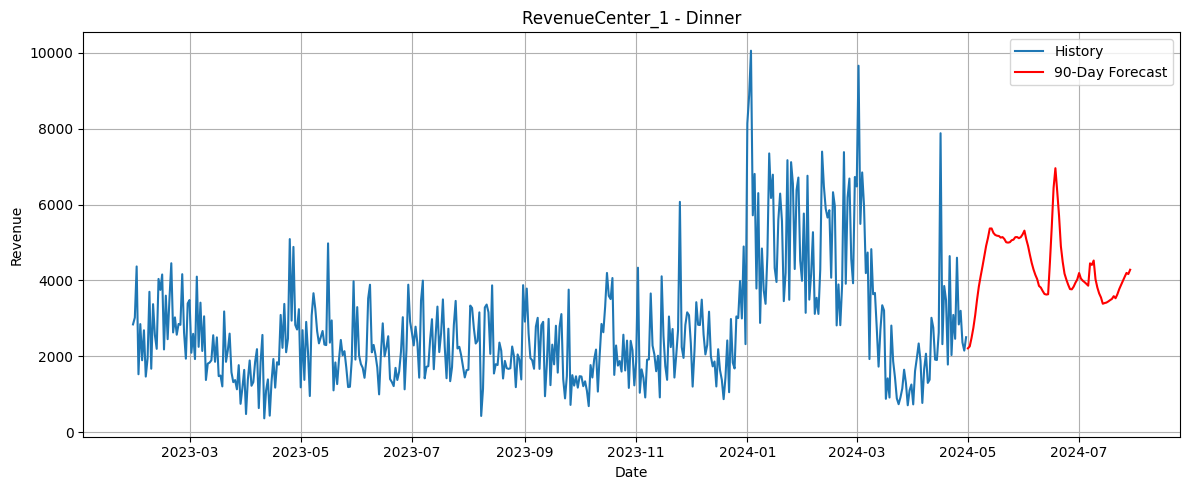

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━

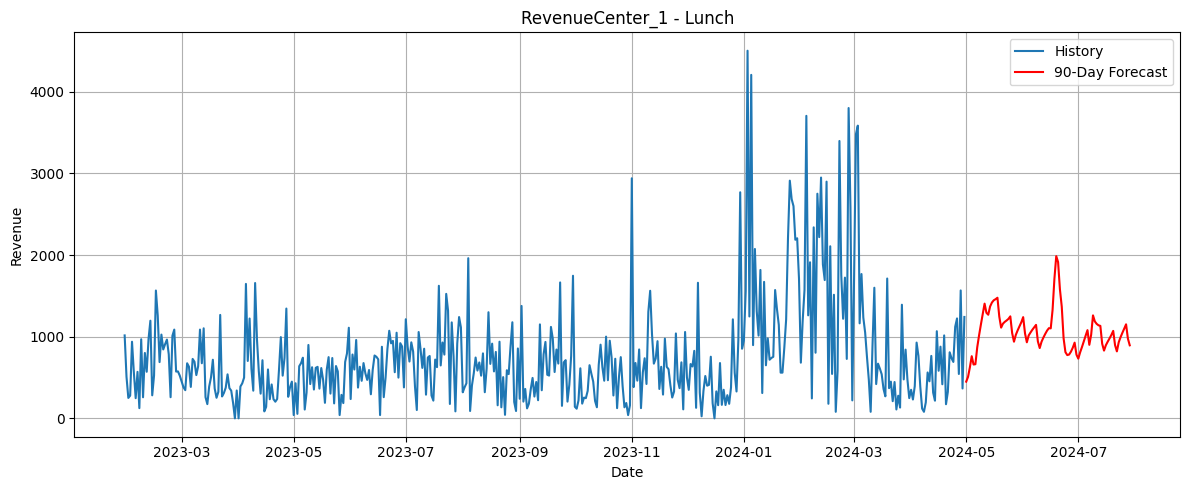

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━

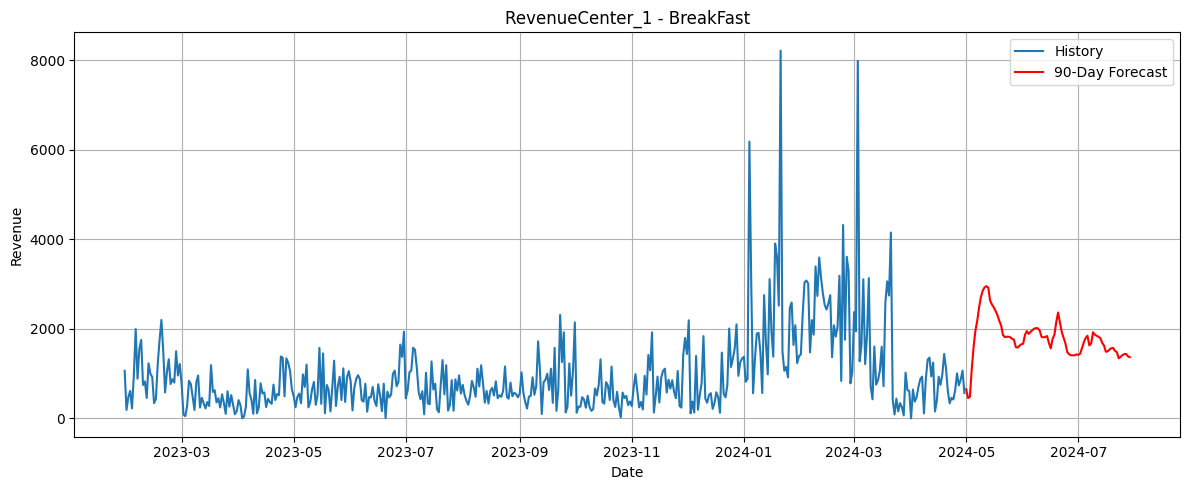

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

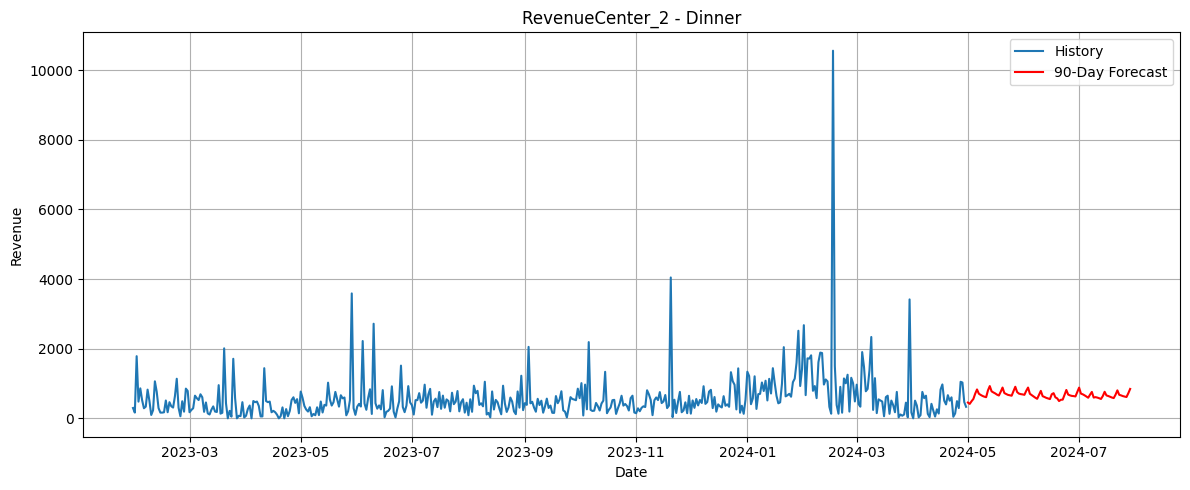

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━

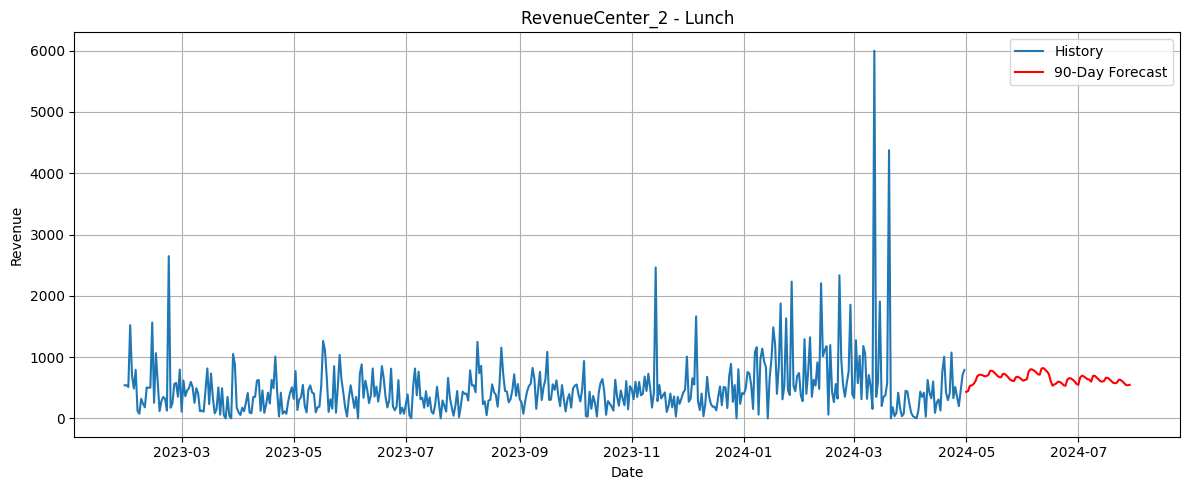

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

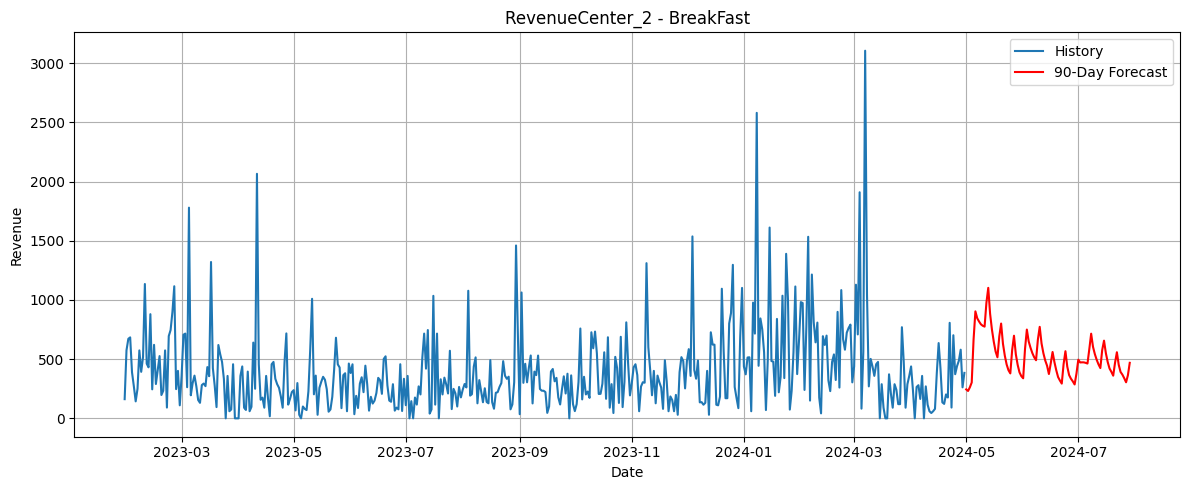

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━

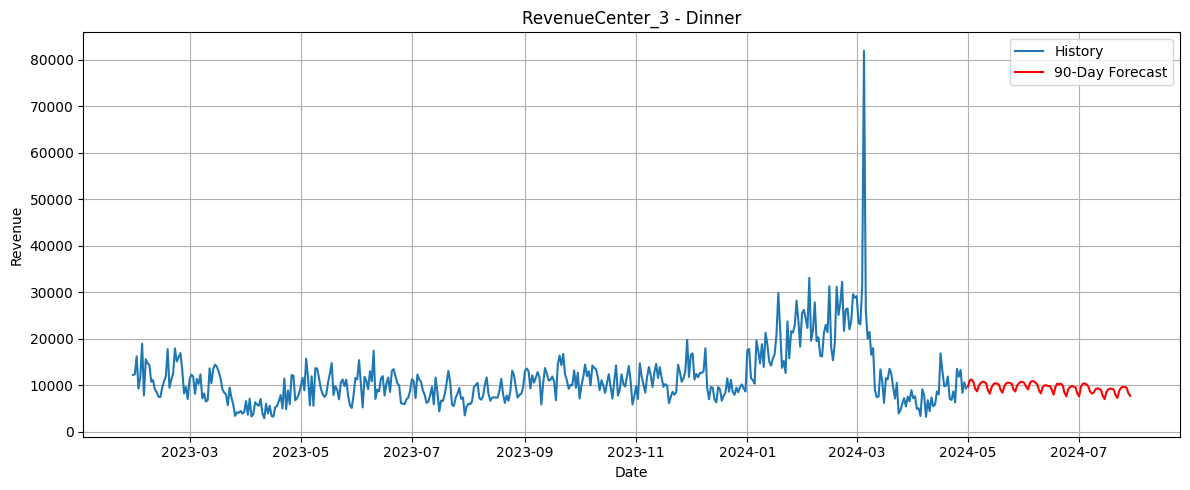

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

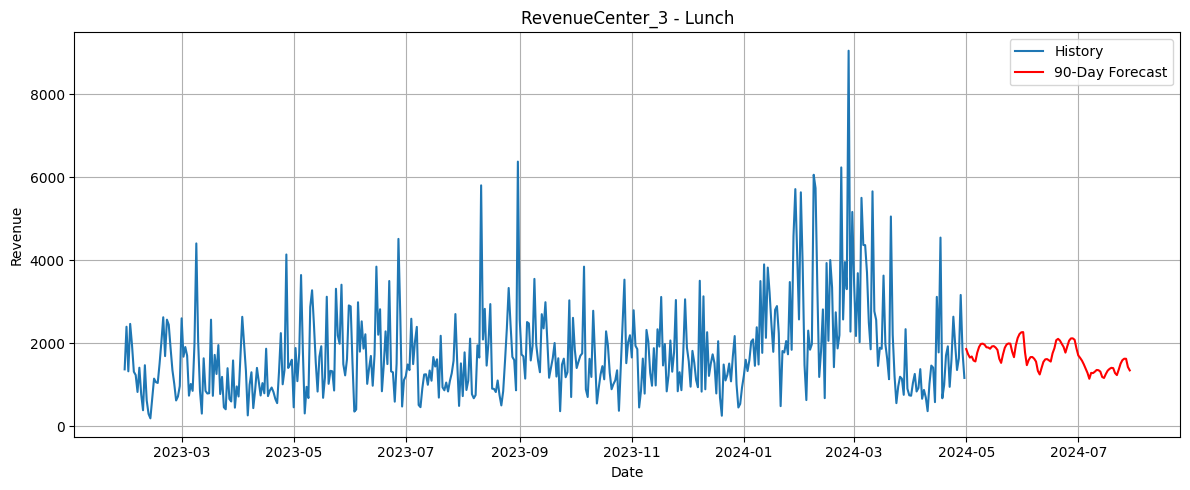

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━

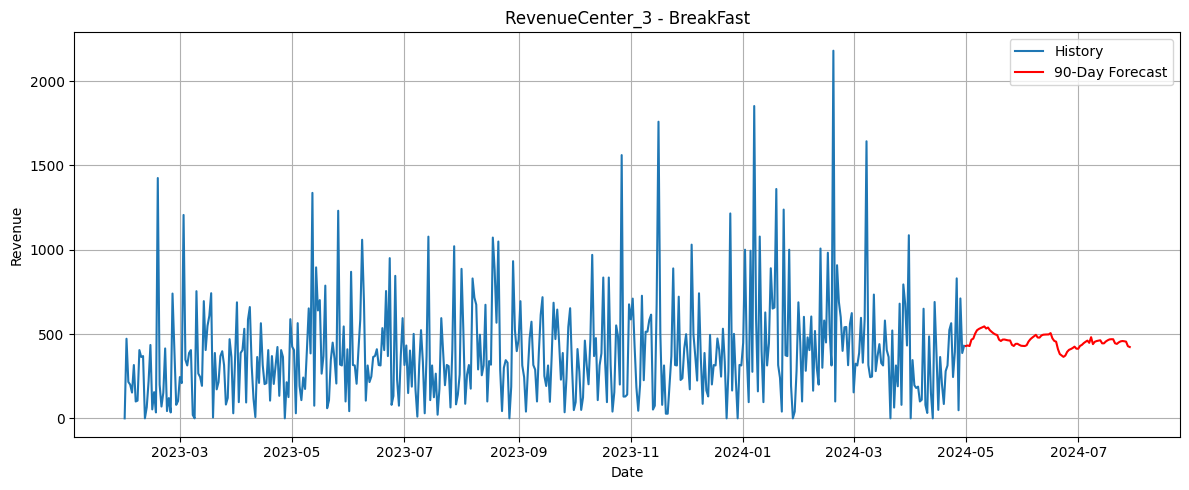

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

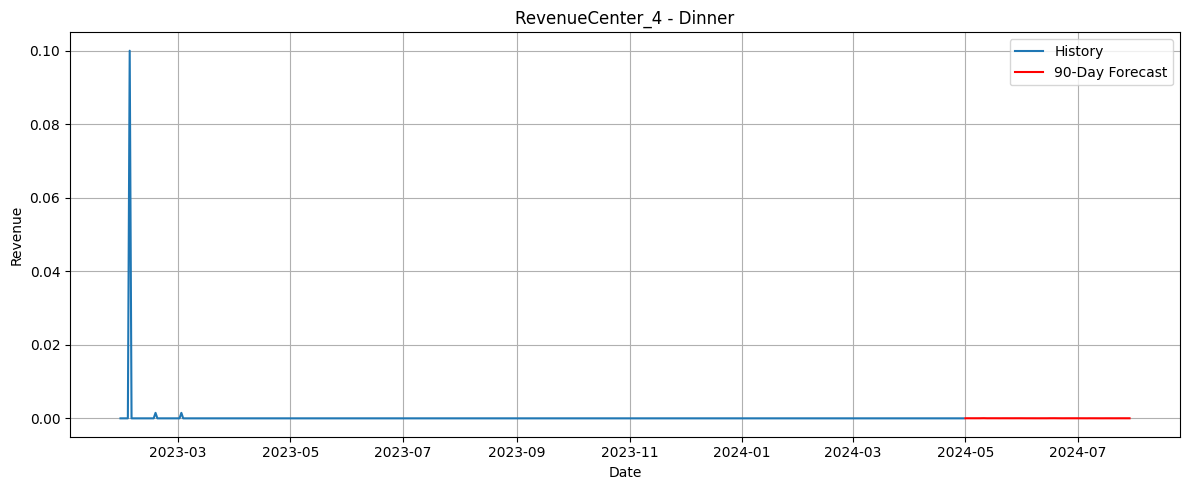

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

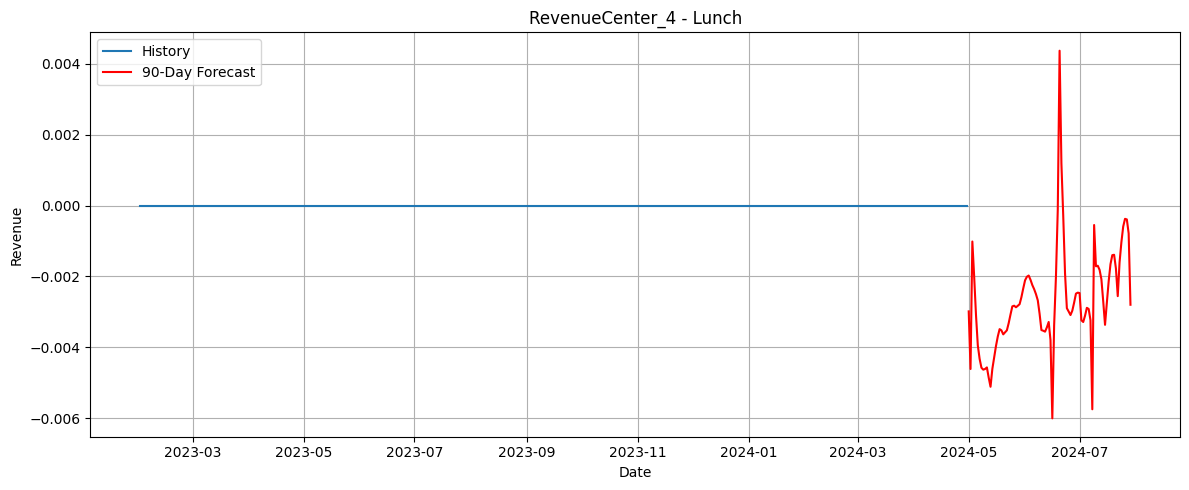

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━

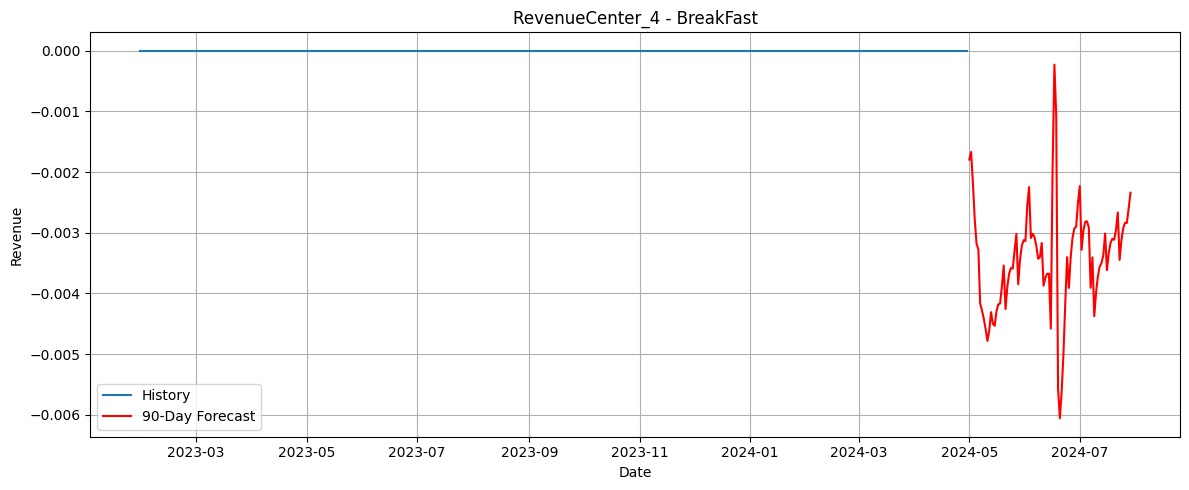

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

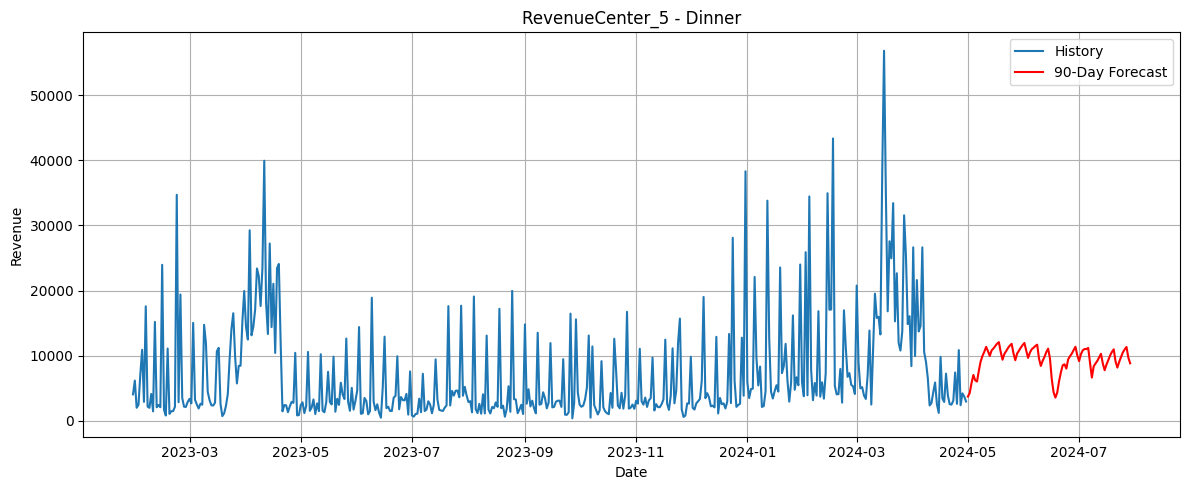

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

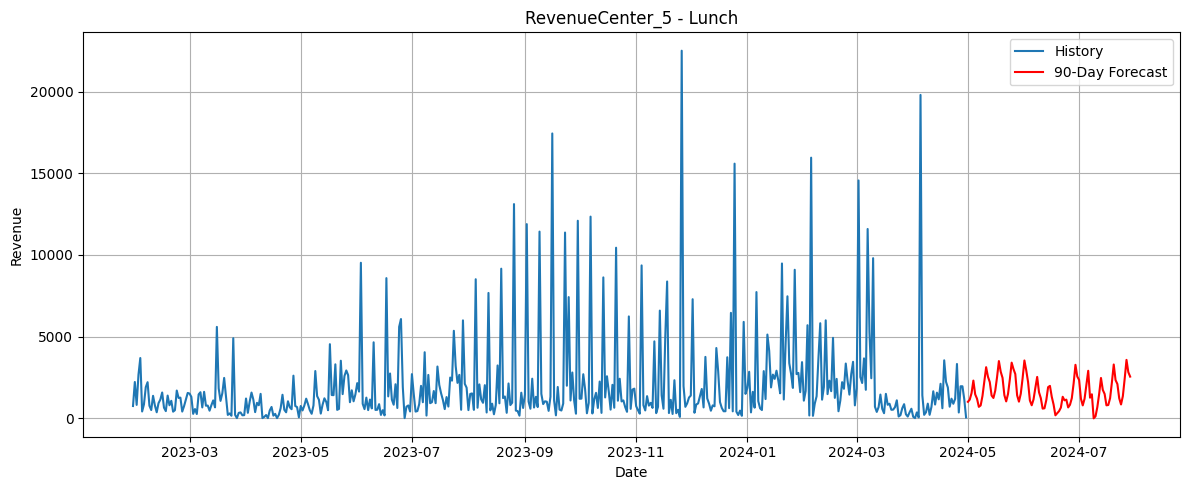

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

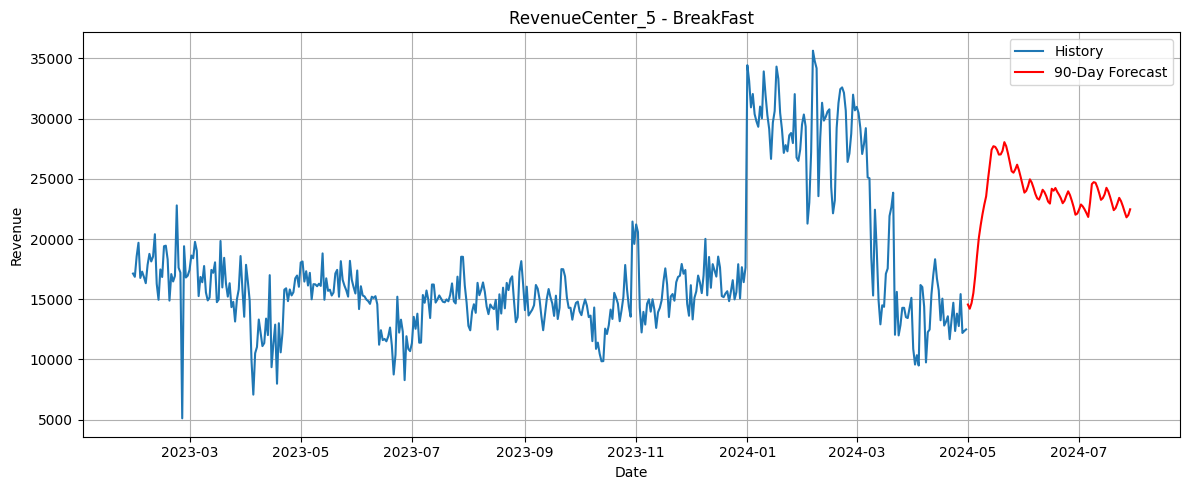

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

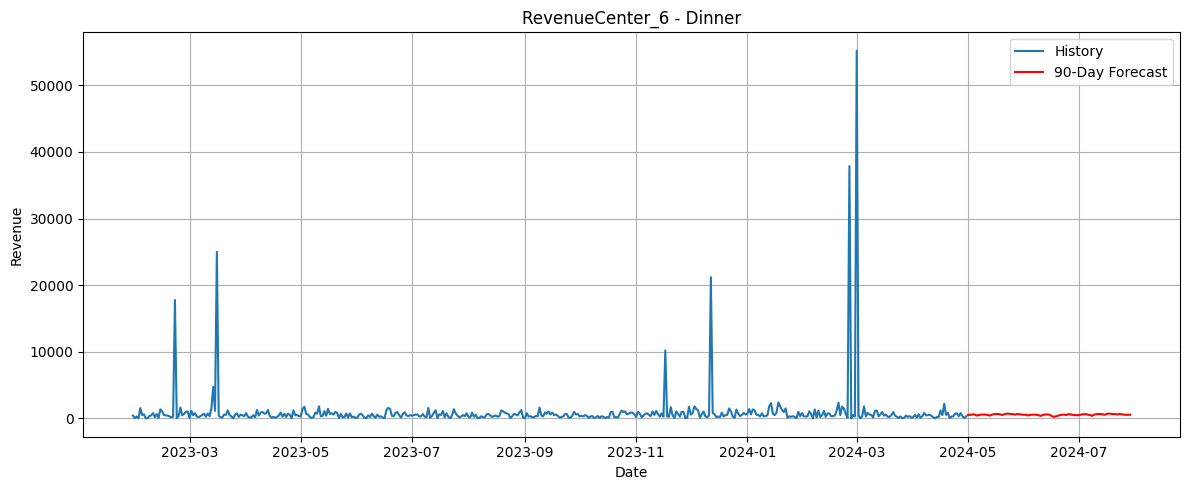

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

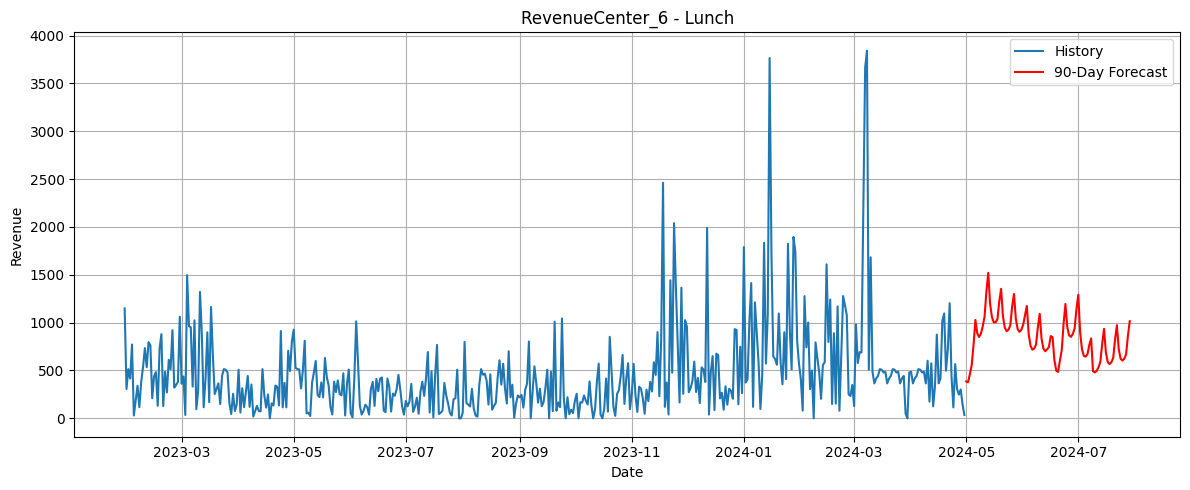

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

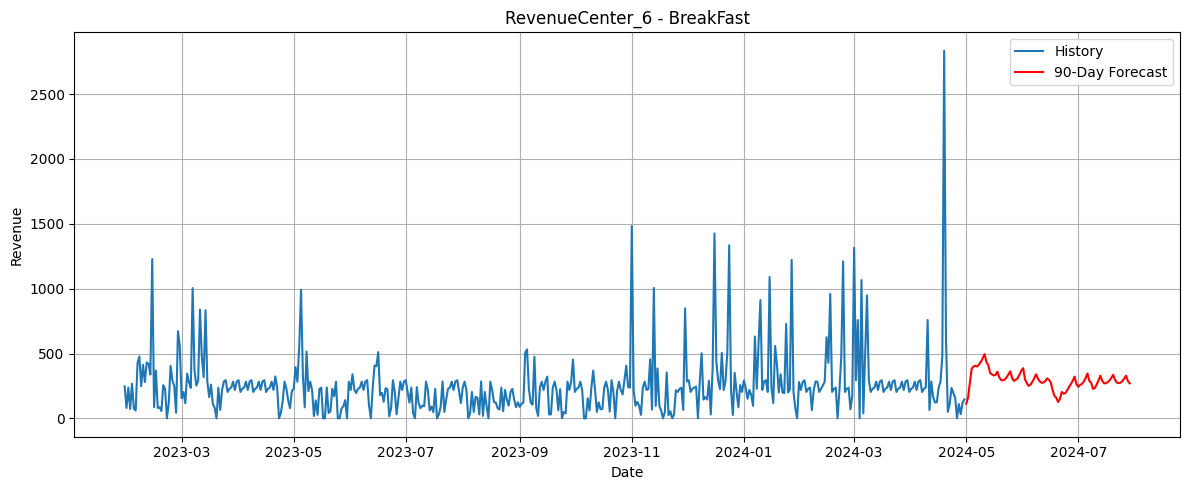

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━

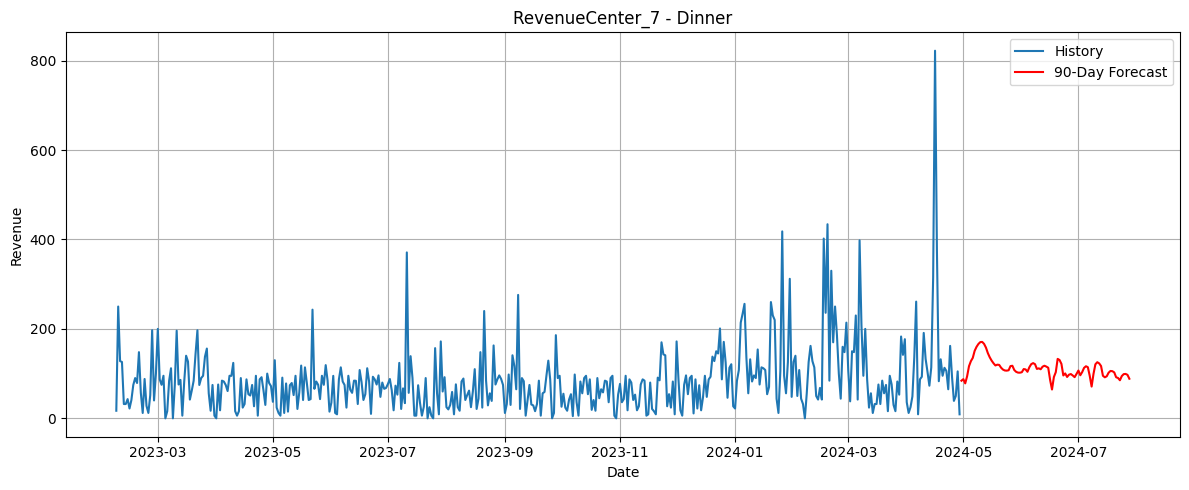

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━

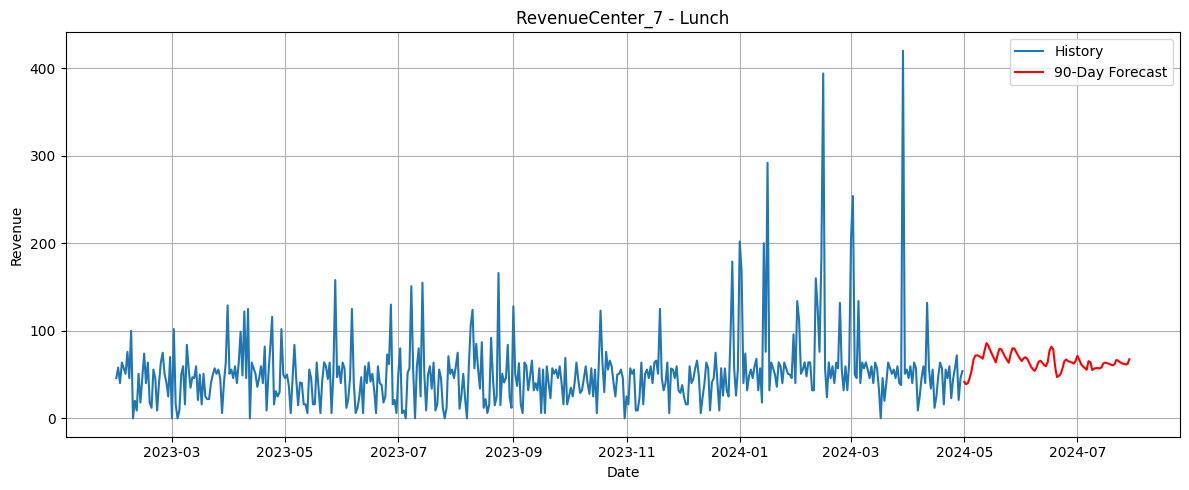

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━

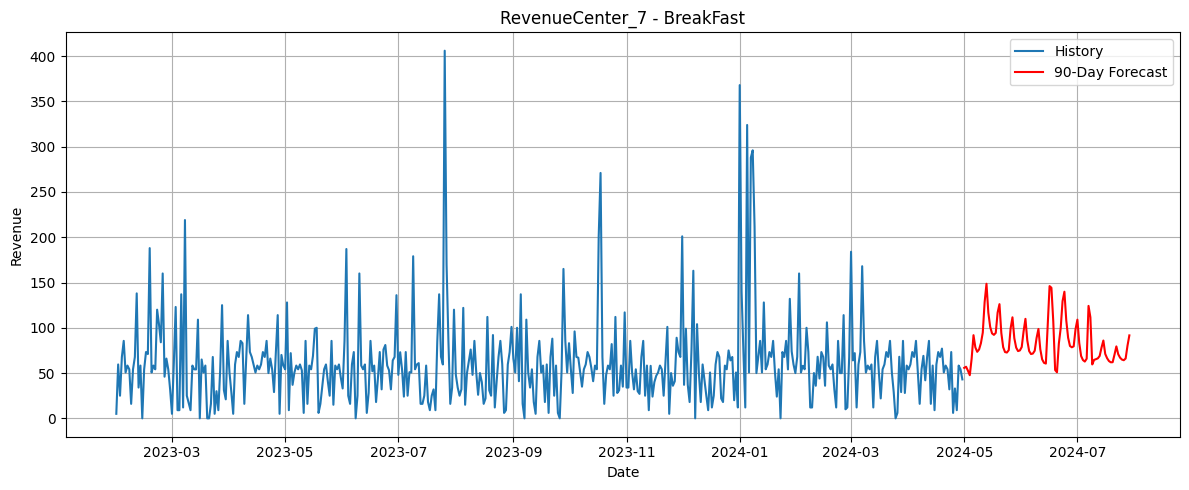

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━

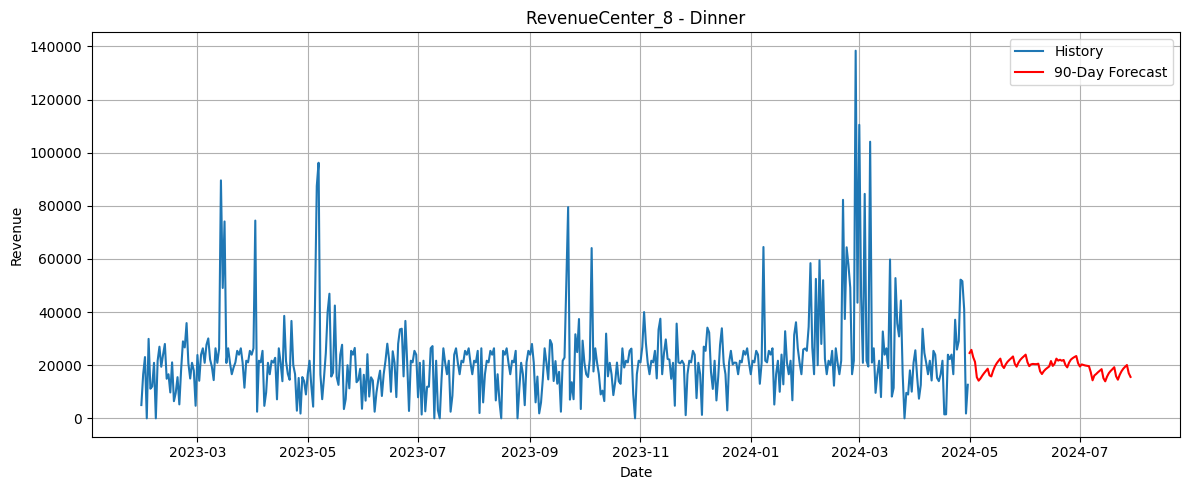

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

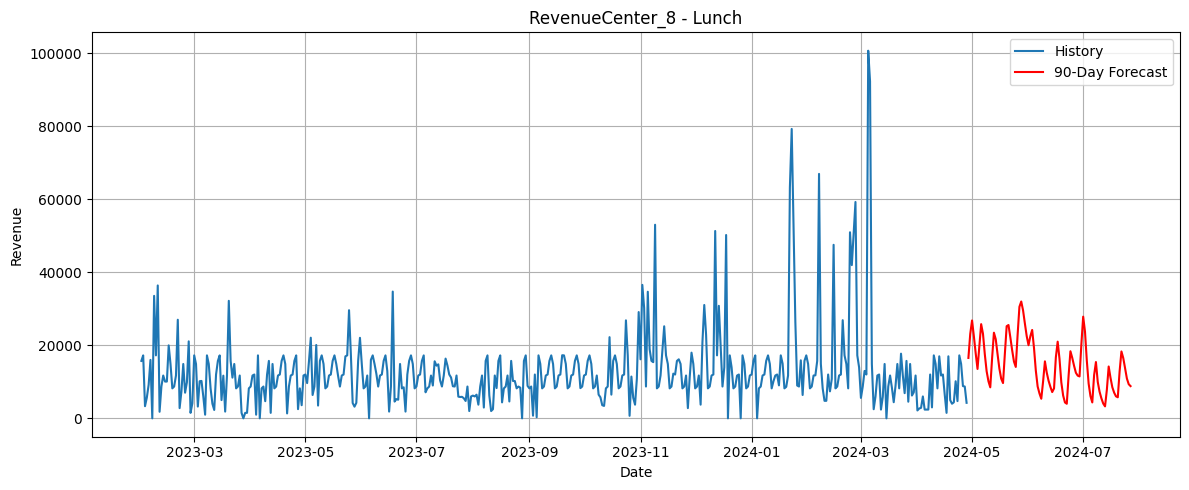

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━

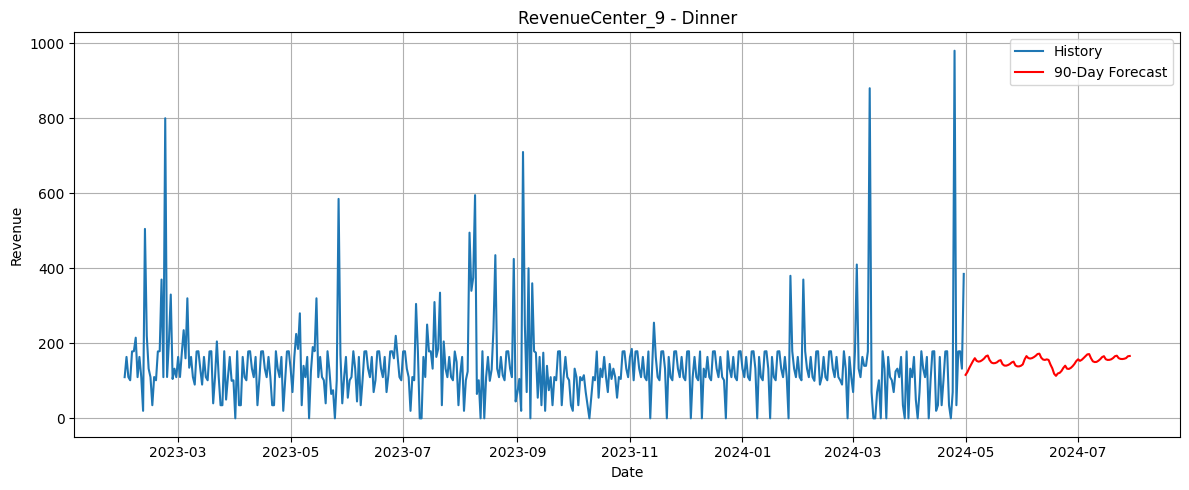

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━

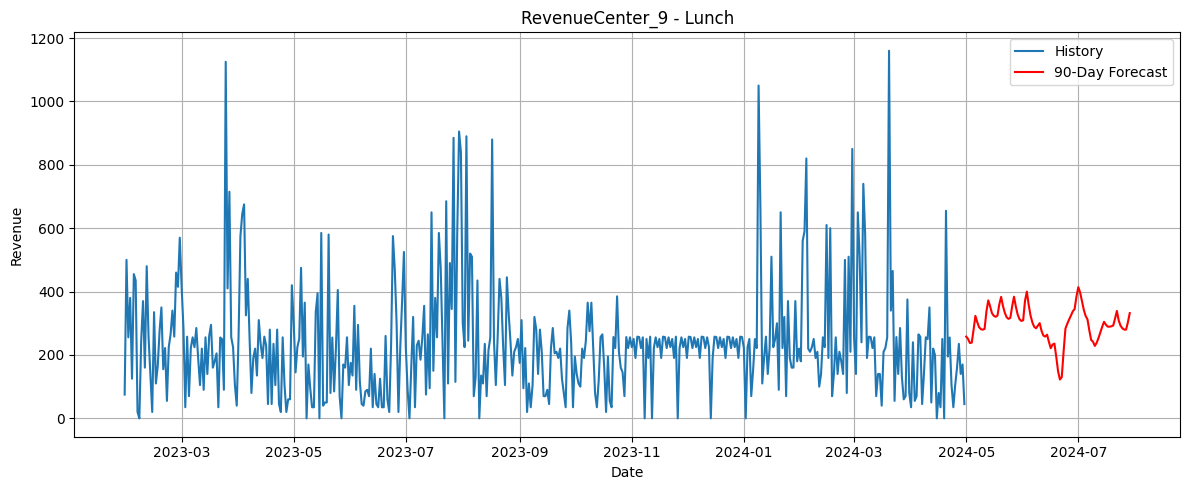

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

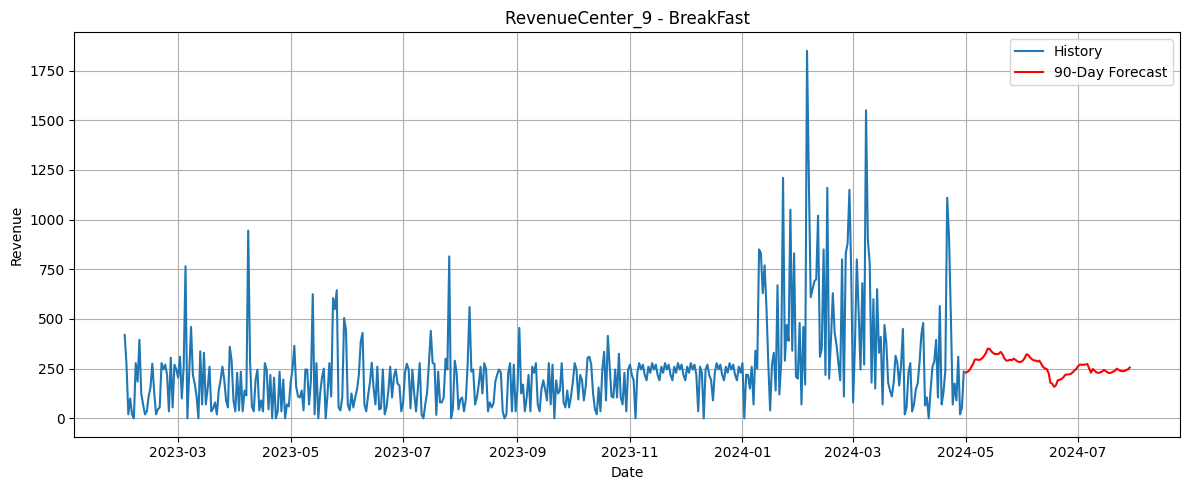

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from datetime import timedelta
import holidays
from hijri_converter import convert
import warnings
warnings.filterwarnings("ignore")

# --- CONFIG ---
DATA_PATH = "/content/Hotel_Revenue_Data.xlsx"
SEQ_LEN = 30
FORECAST_HORIZON = 90
TEST_RATIO = 0.15

# --- LOAD DATA ---
df = pd.read_excel(DATA_PATH, parse_dates=["Date"])
df.rename(columns={
    "MealPeriod": "Meal Period",
    "CheckTotal": "Check Total",
    "RevenueCenterName": "Revenue Center"
}, inplace=True)

# --- STATIC FEATURES ---
uae_hols = holidays.country_holidays("AE", years=range(2010, 2026))
events = {
    "Dubai_Shopping_Festival": pd.date_range("2023-12-15", "2024-01-31"),
    "GITEX_Global": pd.date_range("2024-10-13", "2024-10-17"),
    "Arabian_Travel_Market": pd.date_range("2024-05-06", "2024-05-09"),
    "Dubai_Food_Festival": pd.date_range("2024-05-02", "2024-05-12")
}
def get_ramadan_flag(date):
    try:
        hijri = convert.Gregorian(date.year, date.month, date.day).to_hijri()
        return 1 if hijri.month == 9 else 0
    except:
        return 0
def dubai_temp(date):
    return 0.9 if date.month in [6,7,8] else 0.4 if date.month in [12,1,2] else 0.6

# --- STORAGE ---
forecast_results = {}

# --- LOOP THROUGH COMBINATIONS ---
for center in df["Revenue Center"].unique():
    for meal in df["Meal Period"].unique():
        dfc = df[(df["Revenue Center"] == center) & (df["Meal Period"] == meal)]
        if len(dfc) < 120:
            continue  # skip sparse data

        dfg = dfc.groupby("Date")["Check Total"].sum().reset_index()
        full_range = pd.date_range(dfg["Date"].min(), dfg["Date"].max(), freq="D")
        dfg = dfg.set_index("Date").reindex(full_range).rename_axis("Date").reset_index()
        dow_avg = dfg.groupby(dfg["Date"].dt.dayofweek)["Check Total"].mean()
        dfg["dow_avg"] = dfg["Date"].dt.dayofweek.map(dow_avg)
        dfg["Check Total"] = dfg["Check Total"].fillna(dfg["dow_avg"])
        dfg.drop(columns="dow_avg", inplace=True)

        # --- Features ---
        dfg["DayOfWeek"] = dfg["Date"].dt.dayofweek
        dfg["IsWeekend"] = dfg["DayOfWeek"].isin([5,6]).astype(int)
        dfg["Month"] = dfg["Date"].dt.month
        dfg["DayOfMonth"] = dfg["Date"].dt.day
        dfg["Quarter"] = dfg["Date"].dt.quarter
        dfg["Holiday"] = dfg["Date"].isin(uae_hols).astype(int)
        dfg["Pre_Holiday"] = dfg["Date"].shift(-1).isin(uae_hols).astype(int)
        dfg["Post_Holiday"] = dfg["Date"].shift(1).isin(uae_hols).astype(int)
        dfg["Ramadan"] = dfg["Date"].apply(get_ramadan_flag)
        dfg["Temp_Proxy"] = dfg["Date"].apply(dubai_temp)
        dfg["Event_Impact"] = 1.0
        for dates in events.values():
            dfg.loc[dfg["Date"].isin(dates), "Event_Impact"] = 1.5
        dfg["rolling_mean_7"] = dfg["Check Total"].shift(1).rolling(7).mean()
        dfg["rolling_mean_28"] = dfg["Check Total"].shift(1).rolling(28).mean()
        dfg["rolling_std_7"] = dfg["Check Total"].shift(1).rolling(7).std().fillna(0)
        dfg.dropna(inplace=True)
        dfg.reset_index(drop=True, inplace=True)

        # --- Normalization ---
        features = ["Check Total", "DayOfWeek", "IsWeekend", "Month", "DayOfMonth", "Quarter",
                    "Holiday", "Pre_Holiday", "Post_Holiday", "Ramadan", "Temp_Proxy", "Event_Impact",
                    "rolling_mean_7", "rolling_mean_28", "rolling_std_7"]
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(dfg[features])
        scaled_df = pd.DataFrame(scaled, columns=features)
        dates = dfg["Date"]

        # --- Sequencing ---
        X, y = [], []
        for i in range(SEQ_LEN, len(scaled_df)):
            X.append(scaled_df.iloc[i-SEQ_LEN:i].values)
            y.append(scaled_df.iloc[i]["Check Total"])
        X, y = np.array(X), np.array(y)

        if len(X) < 60:
            continue

        # --- Split ---
        split = int((1 - TEST_RATIO) * len(X))
        X_train, X_test = X[:split], X[split:]
        y_train, y_test = y[:split], y[split:]

        # --- Model ---
        model = Sequential([
            LSTM(64, input_shape=(X.shape[1], X.shape[2])),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=0)

        # --- Forecast next 90 days ---
        last_sequence = scaled_df.iloc[-SEQ_LEN:].values
        future_forecasts = []
        future_dates = []

        for i in range(FORECAST_HORIZON):
            input_seq = last_sequence.reshape(1, SEQ_LEN, -1)
            pred_scaled = model.predict(input_seq)[0, 0]
            last_date = dates.iloc[-1] + timedelta(days=i+1)

            new_row = {
                "Check Total": pred_scaled,
                "DayOfWeek": last_date.dayofweek / 6,
                "IsWeekend": int(last_date.dayofweek >= 5),
                "Month": (last_date.month - 1) / 11,
                "DayOfMonth": (last_date.day - 1) / 30,
                "Quarter": (last_date.quarter - 1) / 3,
                "Holiday": int(last_date in uae_hols),
                "Pre_Holiday": int((last_date + timedelta(days=1)) in uae_hols),
                "Post_Holiday": int((last_date - timedelta(days=1)) in uae_hols),
                "Ramadan": get_ramadan_flag(last_date),
                "Temp_Proxy": dubai_temp(last_date),
                "Event_Impact": 1.5 if any(last_date in d for d in events.values()) else 1.0,
                "rolling_mean_7": np.mean(last_sequence[-7:, 0]),
                "rolling_mean_28": np.mean(last_sequence[-28:, 0]) if len(last_sequence) >= 28 else np.mean(last_sequence[:, 0]),
                "rolling_std_7": np.std(last_sequence[-7:, 0])
            }
            new_scaled = np.array([new_row[col] for col in features])
            future_forecasts.append(new_row["Check Total"])
            future_dates.append(last_date)
            last_sequence = np.vstack([last_sequence[1:], new_scaled])

        inv_forecasts = scaler.inverse_transform(
            np.hstack([
                np.array(future_forecasts).reshape(-1, 1),
                np.tile(scaled_df.iloc[-1, 1:].values, (FORECAST_HORIZON, 1))
            ])
        )[:, 0]

        # --- Save & Plot ---
        forecast_df = pd.DataFrame({
            "Date": future_dates,
            "Forecast": inv_forecasts
        })
        forecast_results[(center, meal)] = forecast_df

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(dfg["Date"], dfg["Check Total"], label="History")
        plt.plot(forecast_df["Date"], forecast_df["Forecast"], label="90-Day Forecast", color='red')
        plt.title(f"{center} - {meal}")
        plt.xlabel("Date")
        plt.ylabel("Revenue")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# forecast_results now holds a DataFrame for each Revenue Center × Meal Period combo
